C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500


C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0738 - val_loss: 0.0395
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0135 - val_loss: 0.0014
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 3.3000e-04
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - val_loss: 7.7559e-04
Epoch 8/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 4.3880e-04
Epoch 9/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 7.6199e-04
Epoch 10/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.9084e-04 - val_loss: 5.2630e-04
Epoch 11/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.0543e-04 - val_loss: 4.5269e-04
Epoch 12/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 

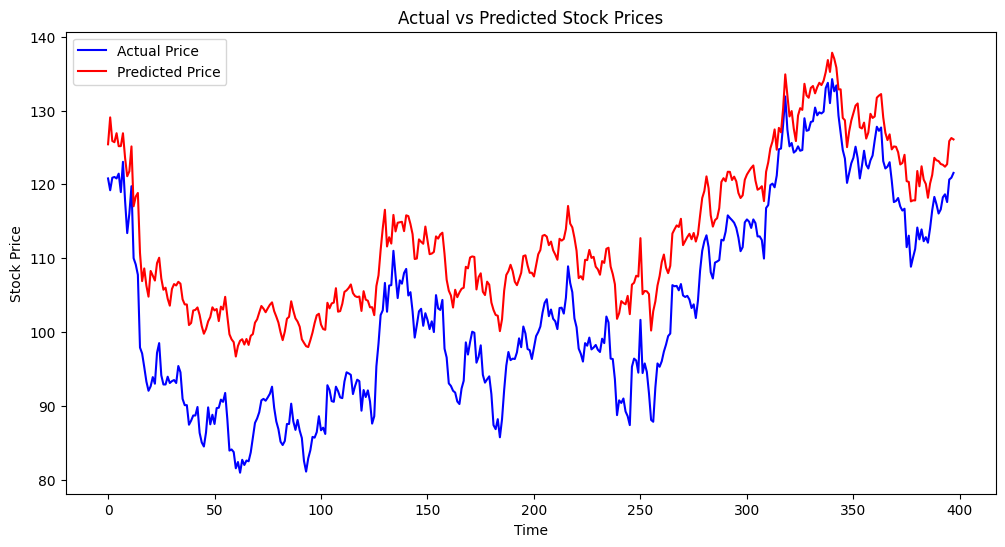

Prediction Complete.


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Stock Data
def load_stock_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

# Feature Engineering
def create_features(df):
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
    df['Momentum'] = df['Close'].diff(5)
    df['Volatility'] = df['Close'].rolling(window=10).std()
    df.dropna(inplace=True)
    return df

# LSTM-based Feature Selection
def lstm_feature_selection(X, y):
    selected_features = np.zeros(X.shape[1])
    
    for i in range(X.shape[1]):
        model = Sequential([
            LSTM(10, input_shape=(1, 1)),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        
        X_train = X[:, i].reshape(-1, 1, 1)
        model.fit(X_train, y, epochs=10, batch_size=16, verbose=0)
        score = model.evaluate(X_train, y, verbose=0)
        selected_features[i] = score
    
    best_features = selected_features < np.median(selected_features)
    return best_features

# Prepare Data
def prepare_data(df):
    feature_cols = ['SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'Momentum', 'Volatility']
    X = df[feature_cols].values
    y = df['Close'].values
    
    best_features = lstm_feature_selection(X, y)
    X_selected = X[:, best_features]
    
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_selected)
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    train_size = int(0.8 * len(X))
    X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
    y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y, y

# Build LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train and Predict
def train_predict_lstm(X_train, X_test, y_train, y_test, scaler_y):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    
    predictions = model.predict(X_test)
    predictions = scaler_y.inverse_transform(predictions)
    y_actual = scaler_y.inverse_transform(y_test)
    
    mse = mean_squared_error(y_actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual, predictions)
    r2 = r2_score(y_actual, predictions)
    
    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_actual, label='Actual Price', color='blue')
    plt.plot(predictions, label='Predicted Price', color='red')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title('Actual vs Predicted Stock Prices')
    plt.legend()
    plt.show()
    
    return model, predictions

# Main Execution
if __name__ == "__main__":
    file_path = 'NSE-TATAGLOBAL.csv'
    df = load_stock_data(file_path)
    df = create_features(df)
    X_train, X_test, y_train, y_test, scaler_X, scaler_y, y_actual = prepare_data(df)
    model, predictions = train_predict_lstm(X_train, X_test, y_train, y_test, scaler_y)
    print("Prediction Complete.")
